# Finding the path of dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


# Imorting Libraries

In [3]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=5fccdad36ee4d5812689e959daa5922769570780e0226382016bbf2b2950bd04
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from keras.utils import to_categorical
from joblib import dump, load

# Reading the dataset

In [6]:
text = []
clas = []
df = pd.read_csv('/content/drive/MyDrive/diploma/train.csv')
text = df['tweet'].tolist()
clas = df['class'].tolist()

# creating a new dataframe for easy text processing

In [7]:
df = pd.DataFrame({'tweet': text, 'class': clas})

# Finding if there is any missing data

In [8]:
print(df.isnull().sum())

tweet    0
class    0
dtype: int64


# Converting the data into lower case.

In [9]:
df['tweet'] = df['tweet'].apply(lambda x:x.lower())

# removing punctuations

In [10]:
punctuation_signs = list("?:!.,;")
df['tweet'] = df['tweet']

for punct_sign in punctuation_signs:
    df['tweet'] = df['tweet'].str.replace(punct_sign, '')

# Removing '\n' and '\t', extra spaces, quoting text, and progressive pronouns.

In [11]:
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("'s", "")

# removing stop-words

In [12]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Using Bag of Words approach for final data Preparation.¶

In [14]:
cv = CountVectorizer(max_features = 75)
X = cv.fit_transform(df['tweet']).toarray()
y = df['class']

# Splitting the Data using Stratified split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Using Random Forest Classifier as the Model and printing evaluating it using confusion matrix

accuracy is:  0.8281102891728312


['rf.joblib']

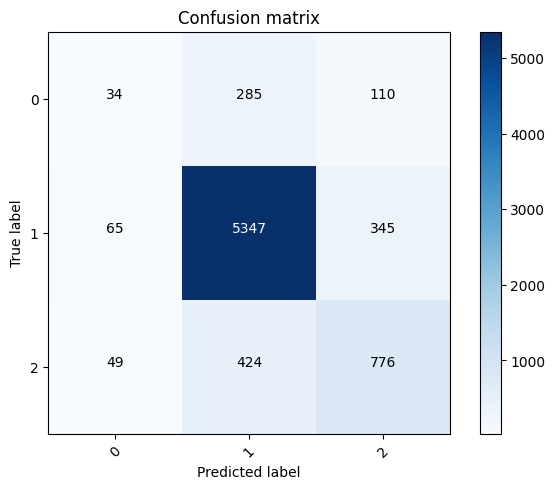

In [17]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(3))
dump(clf, 'rf.joblib')

# Using Decision tree as the Model and printing evaluating it using confusion matrix

accuracy is:  0.792871553463349


['decision.joblib']

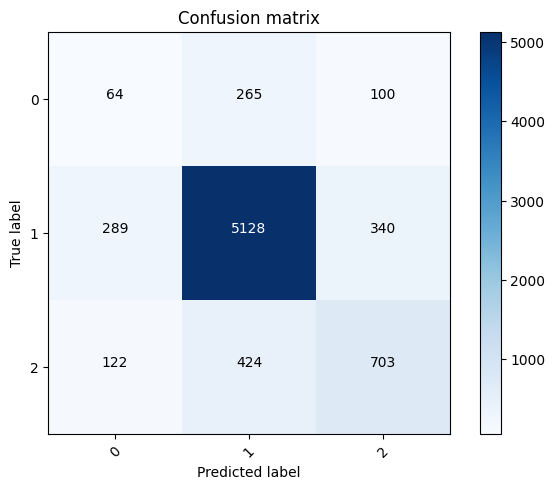

In [18]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(3))
dump(clf, 'decision.joblib')

# Using AdaBoost Classifier as the Model and printing evaluating it using confusion matrix

accuracy is:  0.839946200403497


['ada.joblib']

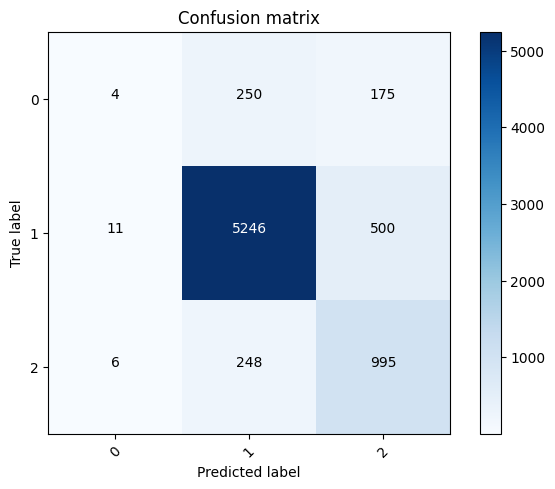

In [19]:
clf = AdaBoostClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(3))
dump(clf, 'ada.joblib')

# Converting the labels into categorical format

In [20]:
y_train=to_categorical(y_train, num_classes = 3, dtype='float32')
y_test=to_categorical(y_test, num_classes = 3, dtype='float32')

# Creating and Training an LSTM Model

In [22]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/20
272/272 [==============================] - 78s 260ms/step - loss: 0.4235 - accuracy: 0.7714 - val_loss: 0.4026 - val_accuracy: 0.7743
Epoch 2/20
272/272 [==============================] - 71s 259ms/step - loss: 0.4027 - accuracy: 0.7743 - val_loss: 0.4023 - val_accuracy: 0.7743
Epoch 3/20
272/272 [==============================] - 70s 259ms/step - loss: 0.4015 - accuracy: 0.7743 - val_loss: 0.4013 - val_accuracy: 0.7743
Epoch 4/20
272/272 [==============================] - 71s 262ms/step - loss: 0.4004 - accuracy: 0.7743 - val_loss: 0.4013 - val_accuracy: 0.7743
Epoch 5/20
272/272 [==============================] - 69s 255ms/step - loss: 0.4001 - accuracy: 0.7743 - val_loss: 0.4011 - val_accuracy: 0.7743
Epoch 6/20
272/272 [==============================] - 69s 255ms/step - loss: 0.4002 - accuracy: 0.7743 - val_loss: 0.4014 - val_accuracy: 0.7743
Epoch 7/20
272/272 [==============================] - 69s 254ms/step - loss: 0.3996 - accuracy: 0.7743 - val_loss: 0.4015 - val_ac

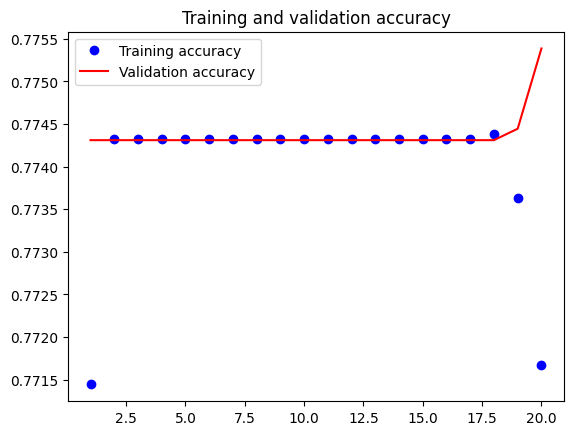

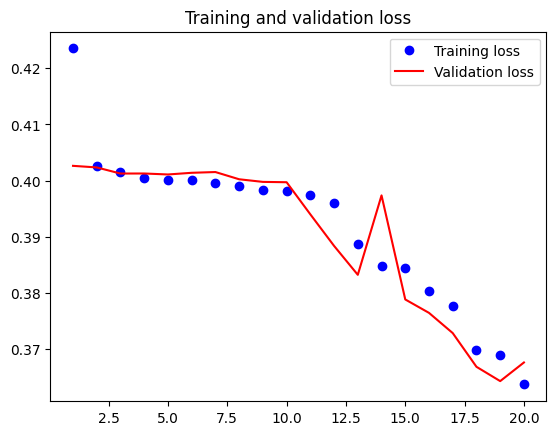

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Saving the LSTM Model

In [25]:
model.save('/content/drive/MyDrive/diploma/lstm.h5')

In [52]:
import numpy as np

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x, h_prev, c_prev):
        # Concatenate h_prev and x
        combined = np.vstack((h_prev, x))

        # Forget gate
        ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)

        # Input gate
        it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        ct_tilde = self.tanh(np.dot(self.Wc, combined) + self.bc)

        # New cell state
        ct = ft * c_prev + it * ct_tilde

        # Output gate
        ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        ht = ot * self.tanh(ct)

        return ht, ct

class CustomLSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = BasicLSTMCell(input_size, hidden_size)

    def forward(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        outputs = []

        for x in inputs:
            x = x.reshape(-1, 1)  # Reshape x to (input_size, 1)
            h, c = self.cell.forward(x, h, c)
            outputs.append(h)

        return outputs, (h, c)


In [27]:
import tensorflow as tf

class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # Initialize weights and biases here
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units * 4),
                                      initializer='glorot_uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 4),
            initializer='orthogonal',
            name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units * 4,),
                                    initializer='zeros',
                                    name='bias')

    def call(self, inputs, states):
        # Implement the logic for an LSTM cell resulting in output and new states
        prev_output, prev_state = states
        z = tf.matmul(inputs, self.kernel) + tf.matmul(prev_output, self.recurrent_kernel) + self.bias
        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        input_gate = tf.sigmoid(z0)
        forget_gate = tf.sigmoid(z1)
        output_gate = tf.sigmoid(z2)
        new_state = tf.tanh(z3)

        state = forget_gate * prev_state + input_gate * new_state
        output = output_gate * tf.tanh(state)

        return output, [output, state]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros((batch_size, self.units), dtype=dtype),
                tf.zeros((batch_size, self.units), dtype=dtype)]

In [29]:
import tensorflow as tf

class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units * 4),
                                      initializer='glorot_uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 4),
            initializer='orthogonal',
            name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units * 4,),
                                    initializer='zeros',
                                    name='bias')

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        outputs = []
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))

        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            z = tf.matmul(x, self.kernel) + tf.matmul(h, self.recurrent_kernel) + self.bias
            z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

            i = tf.sigmoid(z0)
            f = tf.sigmoid(z1)
            o = tf.sigmoid(z2)
            c_tilde = tf.tanh(z3)

            c = f * c + i * c_tilde
            h = o * tf.tanh(c)
            outputs.append(h)

        outputs = tf.stack(outputs, axis=1)
        return outputs

    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({"units": self.units})
        return config

In [53]:
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units * 4),
                                      initializer='glorot_uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 4),
            initializer='orthogonal',
            name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units * 4,),
                                    initializer='zeros',
                                    name='bias')

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))

        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            z = tf.matmul(x, self.kernel) + tf.matmul(h, self.recurrent_kernel) + self.bias
            z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

            i = tf.sigmoid(z0)
            f = tf.sigmoid(z1)
            o = tf.sigmoid(z2)
            c_tilde = tf.tanh(z3)

            c = f * c + i * c_tilde
            h = o * tf.tanh(c)

        return h  # Return only the last hidden state

    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({"units": self.units})
        return config


In [ ]:
#####
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CustomLSTM(20))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
epochs = 20
batch_size = 64

In [56]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/20
272/272 [==============================] - 26s 48ms/step - loss: 0.4305 - accuracy: 0.7698 - val_loss: 0.4024 - val_accuracy: 0.7743
Epoch 2/20
272/272 [==============================] - 11s 40ms/step - loss: 0.4021 - accuracy: 0.7743 - val_loss: 0.4022 - val_accuracy: 0.7743
Epoch 3/20
272/272 [==============================] - 17s 62ms/step - loss: 0.4010 - accuracy: 0.7743 - val_loss: 0.4012 - val_accuracy: 0.7743
Epoch 4/20
 52/272 [====>.........................] - ETA: 9s - loss: 0.4072 - accuracy: 0.7668

KeyboardInterrupt: 

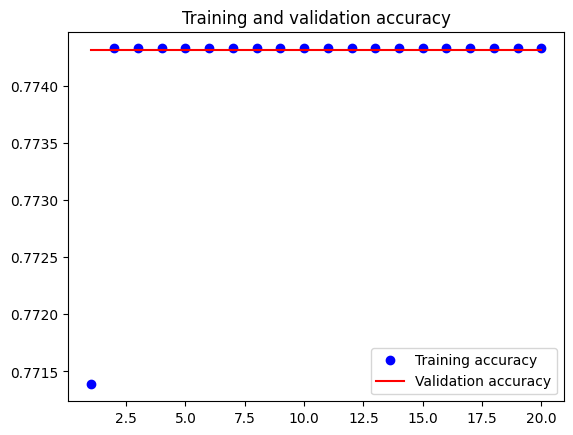

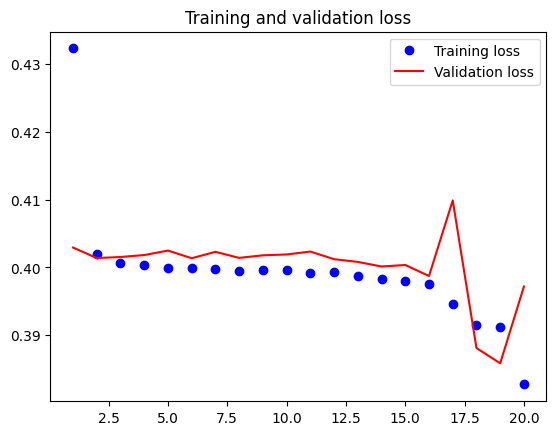

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Medium

In [39]:
import numpy as np

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Initialize weights for the long-term memory components
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size)

        # Initialize weights for the medium-term memory components
        self.Wf_medium = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wi_medium = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wc_medium = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wo_medium = np.random.randn(hidden_size, hidden_size + input_size)

        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

        self.bf_medium = np.zeros((hidden_size, 1))
        self.bi_medium = np.zeros((hidden_size, 1))
        self.bc_medium = np.zeros((hidden_size, 1))
        self.bo_medium = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x, h_prev, c_prev, m_prev):
        combined = np.vstack((h_prev, x))

        ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)
        it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        ct_tilde = self.tanh(np.dot(self.Wc, combined) + self.bc)
        c_new = ft * c_prev + it * ct_tilde

        ft_medium = self.sigmoid(np.dot(self.Wf_medium, combined) + self.bf_medium)
        it_medium = self.sigmoid(np.dot(self.Wi_medium, combined) + self.bi_medium)
        ct_tilde_medium = self.tanh(np.dot(self.Wc_medium, combined) + self.bc_medium)
        m_new = ft_medium * m_prev + it_medium * ct_tilde_medium

        ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        ht = ot * self.tanh(c_new + 0.5 * m_new)

        return ht, c_new, m_new

In [42]:
class CustomLSTM:
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def forward(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        m = np.zeros((self.hidden_size, 1))  # Initialize medium memory
        outputs = []

        for x in inputs:
            x = x.reshape(-1, 1)  # Reshape x to (input_size, 1)
            h, c, m = self.cell.forward(x, h, c, m)
            outputs.append(h)

        return outputs, (h, c, m)


In [43]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CustomLSTM(20))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

TypeError: The added layer must be an instance of class Layer. Received: layer=<__main__.CustomLSTM object at 0x7c0f8ff277c0> of type <class '__main__.CustomLSTM'>.

In [44]:
import tensorflow as tf

class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([units]), tf.TensorShape([units])]  # long, medium, and cell states

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units * 3), initializer='glorot_uniform', name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units * 3), initializer='orthogonal', name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units * 3,), initializer='zeros', name='bias')

    def call(self, inputs, states):
        h_prev, m_prev, c_prev = states
        z = tf.matmul(inputs, self.kernel) + tf.matmul(h_prev, self.recurrent_kernel) + self.bias
        z0, z1, z2 = tf.split(z, 3, axis=1)

        i = tf.sigmoid(z0)
        f = tf.sigmoid(z1)
        o = tf.sigmoid(z2)

        c_new = f * c_prev + i * tf.tanh(z2)  # Cell state update
        m_new = 0.5 * m_prev + 0.5 * c_new  # Medium memory update
        h_new = o * tf.tanh(c_new)  # Hidden state output

        return h_new, [h_new, m_new, c_new]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros((batch_size, self.units), dtype=dtype),
                tf.zeros((batch_size, self.units), dtype=dtype),
                tf.zeros((batch_size, self.units), dtype=dtype)]


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SpatialDropout1D

model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))  # Assume X_train is already defined elsewhere
model.add(SpatialDropout1D(0.2))
model.add(CustomLSTM(20))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__call() missing 1 required positional argument: 'states'


In [49]:
import tensorflow as tf

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights for input and recurrent connections
        initializer = tf.initializers.GlorotUniform()
        self.Wf = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wi = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wc = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wo = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))

        # Biases
        self.bf = tf.Variable(tf.zeros([hidden_size]))
        self.bi = tf.Variable(tf.zeros([hidden_size]))
        self.bc = tf.Variable(tf.zeros([hidden_size]))
        self.bo = tf.Variable(tf.zeros([hidden_size]))

    def forward(self, x, h_prev, c_prev):
        # Concatenate h_prev and x
        combined = tf.concat([h_prev, x], axis=1)

        # LSTM gates using sigmoid activation
        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)
        it = tf.sigmoid(tf.matmul(combined, self.Wi) + self.bi)
        ct_tilde = tf.tanh(tf.matmul(combined, self.Wc) + self.bc)
        ot = tf.sigmoid(tf.matmul(combined, self.Wo) + self.bo)

        # Current cell and hidden state
        c_new = ft * c_prev + it * ct_tilde
        h_new = ot * tf.tanh(c_new)

        return h_new, c_new


In [50]:
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.cell = BasicLSTMCell(units, units)

    def call(self, inputs, states=None):
        if states is None:
            states = [tf.zeros((tf.shape(inputs)[0], self.units)),
                      tf.zeros((tf.shape(inputs)[0], self.units))]

        h_prev, c_prev = states
        outputs = []
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h_prev, c_prev = self.cell.forward(x, h_prev, c_prev)
            outputs.append(h_prev)

        # Stack outputs along time dimension
        outputs = tf.stack(outputs, axis=1)
        return outputs, [h_prev, c_prev]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros((batch_size, self.units), dtype=dtype),
                tf.zeros((batch_size, self.units), dtype=dtype)]


In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(232337, 100, input_length=X_train.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    CustomLSTM(20),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


ValueError: Exception encountered when calling layer "custom_lstm_5" (type CustomLSTM).

in user code:

    File "<ipython-input-50-42fa8cd91a53>", line 16, in call  *
        h_prev, c_prev = self.cell.forward(x, h_prev, c_prev)
    File "<ipython-input-49-4fe55f167e24>", line 26, in forward  *
        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)

    ValueError: Dimensions must be equal, but are 120 and 40 for '{{node custom_lstm_5/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](custom_lstm_5/concat, custom_lstm_5/MatMul/ReadVariableOp)' with input shapes: [?,120], [40,20].


Call arguments received by layer "custom_lstm_5" (type CustomLSTM):
  • inputs=tf.Tensor(shape=(None, 75, 100), dtype=float32)
  • states=None

## two

In [74]:
import numpy as np

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x, h_prev, c_prev):
        # Concatenate h_prev and x
        combined = np.vstack((h_prev, x))

        # Forget gate
        ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)

        # Input gate
        it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        ct_tilde = self.tanh(np.dot(self.Wc, combined) + self.bc)

        # New cell state
        ct = ft * c_prev + it * ct_tilde

        # Output gate
        ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        ht = ot * self.tanh(ct)

        return ht, ct

class CustomLSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = BasicLSTMCell(input_size, hidden_size)
        self.units = units
        self.state_size = units

    def forward(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        outputs = []

        for x in inputs:
            x = x.reshape(-1, 1)  # Reshape x to (input_size, 1)
            h, c = self.cell.forward(x, h, c)
            outputs.append(h)

        return outputs, (h, c)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units * 4),
                                      initializer='glorot_uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 4),
            initializer='orthogonal',
            name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units * 4,),
                                    initializer='zeros',
                                    name='bias')

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))

        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            z = tf.matmul(x, self.kernel) + tf.matmul(h, self.recurrent_kernel) + self.bias
            z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

            i = tf.sigmoid(z0)
            f = tf.sigmoid(z1)
            o = tf.sigmoid(z2)
            c_tilde = tf.tanh(z3)

            c = f * c + i * c_tilde
            h = o * tf.tanh(c)

        return h  # Return only the last hidden state

    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({"units": self.units})
        return config

In [75]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CustomLSTM(20))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

TypeError: CustomLSTM.__init__() missing 1 required positional argument: 'hidden_size'

In [ ]:
epochs = 20
batch_size = 64

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

In [59]:
import numpy as np

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Weights for input, forget, and output gates
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        # Weights for medium memory management
        self.Wm = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        # Biases
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bm = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x, h_prev, c_prev, m_prev):
        combined = np.vstack((h_prev, x))

        ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)
        it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        ct_tilde = self.tanh(np.dot(self.Wc, combined) + self.bc)
        mt = self.sigmoid(np.dot(self.Wm, combined) + self.bm)

        ct = ft * c_prev + it * ct_tilde
        mt_new = mt * m_prev + (1 - mt) * ct  # Combining current input and previous medium memory

        ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        ht = ot * self.tanh(ct + 0.5 * mt_new)  # Using a combination of cell and medium memory for output

        return ht, ct, mt_new

In [60]:
import tensorflow as tf

class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.cell = BasicLSTMCell(units, units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))
        m = tf.zeros((batch_size, self.units))  # Initialize medium memory

        outputs = []
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h, c, m = self.cell.forward(x, h, c, m)
            outputs.append(h)

        outputs = tf.stack(outputs, axis=1)
        return outputs

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros((batch_size, self.units), dtype=dtype),
                tf.zeros((batch_size, self.units), dtype=dtype),
                tf.zeros((batch_size, self.units), dtype=dtype)]  # Also return initial medium memory


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SpatialDropout1D

model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CustomLSTM(20))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


NotImplementedError: Exception encountered when calling layer "custom_lstm_7" (type CustomLSTM).

in user code:

    File "<ipython-input-60-7cc0b2f65362>", line 18, in call  *
        h, c, m = self.cell.forward(x, h, c, m)
    File "<ipython-input-59-c50cf2e25fcd>", line 28, in forward  *
        combined = np.vstack((h_prev, x))
    File "/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py", line 286, in vstack  **
        arrs = atleast_2d(*tup)
    File "/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py", line 121, in atleast_2d
        ary = asanyarray(ary)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (custom_lstm_7/zeros:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


Call arguments received by layer "custom_lstm_7" (type CustomLSTM):
  • inputs=tf.Tensor(shape=(None, 75, 100), dtype=float32)

In [62]:
import tensorflow as tf

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights for input, forget, output gates, and medium memory interactions
        initializer = tf.keras.initializers.GlorotUniform()
        self.Wf = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wi = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wc = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wo = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wm = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))  # For medium memory

        # Biases
        self.bf = tf.Variable(tf.zeros([hidden_size]))
        self.bi = tf.Variable(tf.zeros([hidden_size]))
        self.bc = tf.Variable(tf.zeros([hidden_size]))
        self.bo = tf.Variable(tf.zeros([hidden_size]))
        self.bm = tf.Variable(tf.zeros([hidden_size]))  # For medium memory

    def forward(self, x, h_prev, c_prev, m_prev):
        combined = tf.concat([h_prev, x], 1)

        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)
        it = tf.sigmoid(tf.matmul(combined, self.Wi) + self.bi)
        ct_tilde = tf.tanh(tf.matmul(combined, self.Wc) + self.bc)
        mt = tf.sigmoid(tf.matmul(combined, self.Wm) + self.bm)  # Medium memory gate

        c_new = ft * c_prev + it * ct_tilde
        m_new = mt * m_prev + (1 - mt) * h_prev  # Update medium memory with a mix of previous medium and current hidden state
        ot = tf.sigmoid(tf.matmul(combined, self.Wo) + self.bo)
        h_new = ot * tf.tanh(c_new + m_new)  # Incorporate medium memory into the new hidden state

        return h_new, c_new, m_new


In [63]:
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.cell = BasicLSTMCell(units, units)

    def call(self, inputs, states=None):
        if states is None:
            batch_size = tf.shape(inputs)[0]
            h = tf.zeros((batch_size, self.units))
            c = tf.zeros((batch_size, self.units))
            m = tf.zeros((batch_size, self.units))  # Initial state for medium memory

        outputs = []
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h, c, m = self.cell.forward(x, h, c, m)
            outputs.append(h)

        final_output = outputs[-1]
        return final_output, [h, c, m]

    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({"units": self.units})
        return config


In [64]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CustomLSTM(20))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


ValueError: Exception encountered when calling layer "custom_lstm_8" (type CustomLSTM).

in user code:

    File "<ipython-input-63-61bd0f4ebd32>", line 17, in call  *
        h, c, m = self.cell.forward(x, h, c, m)
    File "<ipython-input-62-e85b28763b0c>", line 26, in forward  *
        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)

    ValueError: Dimensions must be equal, but are 120 and 40 for '{{node custom_lstm_8/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](custom_lstm_8/concat, custom_lstm_8/MatMul/ReadVariableOp)' with input shapes: [?,120], [40,20].


Call arguments received by layer "custom_lstm_8" (type CustomLSTM):
  • inputs=tf.Tensor(shape=(None, 75, 100), dtype=float32)
  • states=None

In [65]:
import tensorflow as tf

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initializer for the weight matrices
        initializer = tf.keras.initializers.GlorotUniform()

        # Weight matrices for the different gates including medium memory management
        self.Wf = tf.Variable(initializer(shape=(hidden_size + input_size, hidden_size)))
        self.Wi = tf.Variable(initializer(shape=(hidden_size + input_size, hidden_size)))
        self.Wc = tf.Variable(initializer(shape=(hidden_size + input_size, hidden_size)))
        self.Wo = tf.Variable(initializer(shape=(hidden_size + input_size, hidden_size)))
        self.Wm = tf.Variable(initializer(shape=(hidden_size + input_size, hidden_size)))  # Weights for medium memory gate

        # Biases for the gates
        self.bf = tf.Variable(tf.zeros([hidden_size]))
        self.bi = tf.Variable(tf.zeros([hidden_size]))
        self.bc = tf.Variable(tf.zeros([hidden_size]))
        self.bo = tf.Variable(tf.zeros([hidden_size]))
        self.bm = tf.Variable(tf.zeros([hidden_size]))  # Bias for medium memory gate

    def forward(self, x, h_prev, c_prev, m_prev):
        # Concatenating the previous hidden state and the input
        combined = tf.concat([h_prev, x], axis=1)

        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)
        it = tf.sigmoid(tf.matmul(combined, self.Wi) + self.bi)
        ct_tilde = tf.tanh(tf.matmul(combined, self.Wc) + self.bc)
        mt = tf.sigmoid(tf.matmul(combined, self.Wm) + self.bm)  # Gate for medium memory

        c_new = ft * c_prev + it * ct_tilde
        m_new = mt * m_prev + (1 - mt) * h_prev  # Updating medium memory
        ot = tf.sigmoid(tf.matmul(combined, self.Wo) + self.bo)
        h_new = ot * tf.tanh(c_new + m_new)  # Output state considering medium memory

        return h_new, c_new, m_new


In [66]:
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.cell = BasicLSTMCell(units, units)

    def call(self, inputs, states=None):
        if states is None:
            batch_size = tf.shape(inputs)[0]
            h = tf.zeros((batch_size, self.units))
            c = tf.zeros((batch_size, self.units))
            m = tf.zeros((batch_size, self.units))  # Initial medium memory state

        outputs = []
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h, c, m = self.cell.forward(x, h, c, m)
            outputs.append(h)

        final_output = tf.stack(outputs, axis=1)
        return final_output, [h, c, m]

    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({"units": self.units})
        return config


In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(232337, 100, input_length=X_train.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    CustomLSTM(20),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

ValueError: Exception encountered when calling layer "custom_lstm_9" (type CustomLSTM).

in user code:

    File "<ipython-input-66-144d37810afa>", line 17, in call  *
        h, c, m = self.cell.forward(x, h, c, m)
    File "<ipython-input-65-565f81dce061>", line 29, in forward  *
        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)

    ValueError: Dimensions must be equal, but are 120 and 40 for '{{node custom_lstm_9/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](custom_lstm_9/concat, custom_lstm_9/MatMul/ReadVariableOp)' with input shapes: [?,120], [40,20].


Call arguments received by layer "custom_lstm_9" (type CustomLSTM):
  • inputs=tf.Tensor(shape=(None, 75, 100), dtype=float32)
  • states=None

In [68]:
import tensorflow as tf

class BasicLSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initializer for the weight matrices
        initializer = tf.keras.initializers.GlorotUniform()

        # Weight matrices for the different gates including medium memory management
        self.Wf = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wi = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wc = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wo = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))
        self.Wm = tf.Variable(initializer(shape=(input_size + hidden_size, hidden_size)))  # Weights for medium memory gate

        # Biases for the gates
        self.bf = tf.Variable(tf.zeros([hidden_size]))
        self.bi = tf.Variable(tf.zeros([hidden_size]))
        self.bc = tf.Variable(tf.zeros([hidden_size]))
        self.bo = tf.Variable(tf.zeros([hidden_size]))
        self.bm = tf.Variable(tf.zeros([hidden_size]))  # Bias for medium memory gate

    def forward(self, x, h_prev, c_prev):
        combined = tf.concat([h_prev, x], axis=1)

        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)
        it = tf.sigmoid(tf.matmul(combined, self.Wi) + self.bi)
        ct_tilde = tf.tanh(tf.matmul(combined, self.Wc) + self.bc)
        mt = tf.sigmoid(tf.matmul(combined, self.Wm) + self.bm)  # Gate for medium memory

        c_new = ft * c_prev + it * ct_tilde
        m_temp = mt * c_prev + (1 - mt) * h_prev  # Temporary medium memory computation
        ot = tf.sigmoid(tf.matmul(combined, self.Wo) + self.bo)
        h_new = ot * tf.tanh(c_new + m_temp)  # Incorporating medium memory influence

        return h_new, c_new


In [69]:
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.cell = BasicLSTMCell(units, units)

    def call(self, inputs, states=None):
        if states is None:
            batch_size = tf.shape(inputs)[0]
            h = tf.zeros((batch_size, self.units))
            c = tf.zeros((batch_size, self.units))

        outputs = []
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h, c = self.cell.forward(x, h, c)
            outputs.append(h)

        final_output = tf.stack(outputs, axis=1)
        return final_output, [h, c]

    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({"units": self.units})
        return config


In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SpatialDropout1D

model = Sequential([
    Embedding(232337, 100, input_length=X_train.shape[1]),
    SpatialDropout1D(0.2),
    CustomLSTM(20),
    Dense(3, activation='softmax')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


ValueError: Exception encountered when calling layer "custom_lstm_10" (type CustomLSTM).

in user code:

    File "<ipython-input-69-f7be20e6db39>", line 16, in call  *
        h, c = self.cell.forward(x, h, c)
    File "<ipython-input-68-0ae5488d7547>", line 28, in forward  *
        ft = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)

    ValueError: Dimensions must be equal, but are 120 and 40 for '{{node custom_lstm_10/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](custom_lstm_10/concat, custom_lstm_10/MatMul/ReadVariableOp)' with input shapes: [?,120], [40,20].


Call arguments received by layer "custom_lstm_10" (type CustomLSTM):
  • inputs=tf.Tensor(shape=(None, 75, 100), dtype=float32)
  • states=None